In [1]:
%pip install mlflow

Defaulting to user installation because normal site-packages is not writeable
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 28.3/28.3 MB 230.6 kB/s eta 0:00:0000:0200:04
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.0/6.0 MB 273.9 kB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 643.8/643.8 kB 246.0 kB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 306.6 kB/s eta 0:00:00a 0:00:01

[notice] A new release of pip is available: 24.3.1 -> 25.0
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
import mlflow

mlflow.set_tracking_uri(uri="http://localhost:5000")
mlflow.sklearn.autolog()

from datetime import datetime
import warnings
warnings.filterwarnings('ignore')
from tqdm import tqdm

In [4]:


df_x_train = pd.read_csv('nurse_data_train.csv')
df_x_test = pd.read_csv('nurse_data_test.csv')

y_train=np.array(df_x_train['label'])
df_x_train=df_x_train.drop('label', axis=1)
y_test=np.array(df_x_test['label'])
df_x_test=df_x_test.drop('label', axis=1)


original_columns = df_x_train.columns


from sklearn.preprocessing import MinMaxScaler

min_max=MinMaxScaler().fit(df_x_train)
df_x_train=min_max.transform(df_x_train)
df_x_test=min_max.transform(df_x_test)




In [5]:
df_x_train.shape, df_x_test.shape

((267424, 19), (89142, 19))

# zad 1
## metryka oceniająca klasyfikacje

- proszę o wyjaśnienie powodu, dlaczego otrzymujemy wysoki wynik oceny modelu, a na wykresie obserwujemy całkowity brak prawidłowej predykcji dla jednej z klas
- proszę o propozycje kilku metryk, które mogą być przydatne przy naszym zagadnieniu z wyjaśnieniem dlaczego taki wybór

In [6]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, classification_report

accuracy na zbiorze testowym: 98.4 %

Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.95      0.97     16884
           1       0.95      0.97      0.96      6045
           2       0.99      0.99      0.99     66213

    accuracy                           0.98     89142
   macro avg       0.97      0.97      0.97     89142
weighted avg       0.98      0.98      0.98     89142



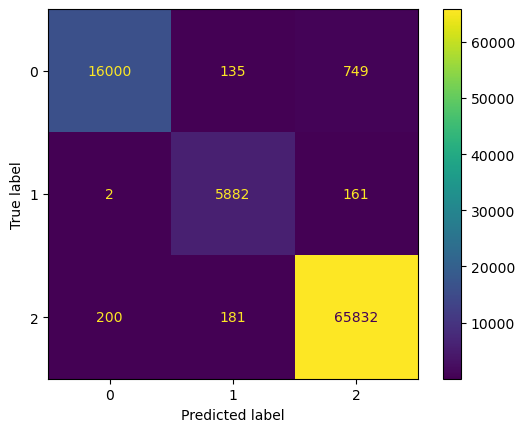

In [58]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

model=DecisionTreeClassifier(random_state=42, max_depth=11)
model.fit(df_x_train, y_train)


y_pred = model.predict(df_x_test)
                       
print('accuracy na zbiorze testowym: {} %'.format(round(accuracy_score(y_test, y_pred)*100, 1)))

print("\nClassification Report:\n", classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, model.predict(df_x_test), labels=model.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                               display_labels=model.classes_)
disp.plot()
plt.show()

In [28]:
import uuid

# zad 2
## dobór hiperparametrów poprzez walidację krzyżową + MLFlow

- proszę o uzasadnienie dlaczego wykorzystuje się walidacje krzyżową do strojenia modelu i na czym ona polega
- proszę o przygotowanie strojenia hiperparametrów metodą GridSearch dla modeli [DecisionTreeClassifier, RandomForestClassifier, MLPClassifier, LogisticRegression, SVC, KNeighborsClassifier] (UWAGA: wystarczą dwa parametry per model)
- dla modeli DecisionTree, RandomForest oraz LogisticRegression pokazać na wykresach znaczenie poszczególnych kolumn w danych 
- proszę o krótką charakterystykę powyższych modeli oraz strojonych w nich hiperparametrów

## MLFlow
- połączone z Metody składowania danych w systemach SI lab4
    - całość proszę rejestrować przy użyciu platformy MLFlow (może być wymagana konfiguracja)
    - proszę skożystać z autologowania sklearn oraz dołączyć wybraną przez siebie bardziej zaawansowaną metrykę
    - na podstawie wybranej przez państwa metryki, na platformie MLFlow proszę o wskazanie najlepszego modelu do badanego zagadnienia 

In [31]:
def func_plot_gridsearch(results):
    params=['param_'+ i for i in results['params'][0].keys()]
    
    df=pd.DataFrame()
    df['mean_valid_score']=results['mean_test_score']
    df['fit_time']=results['mean_fit_time']
    
    for p in params:
        df[p]=results[p]
    display(df)
    
    for p in params:
        fig, ax = plt.subplots(figsize=(10,8))
        sns.scatterplot(df,
                       x=p,
                       y='mean_valid_score',
                       hue='fit_time',
                        legend='brief'
                       )
        plt.show()

def func_plot_importance(original_columns, dt_feature_importance):

    feature_importance_df = pd.DataFrame({
        'feature': original_columns,
        'importance': dt_feature_importance
    })

    feature_importance_df = feature_importance_df.sort_values('importance', ascending=False)
    plt.figure(figsize=(12, 8))  
    plt.bar(feature_importance_df['feature'], feature_importance_df['importance'])
    plt.xlabel('Features')
    plt.ylabel('Importance')
    plt.title('Feature Importance')

    for i, v in enumerate(feature_importance_df['importance']):
        plt.text(i, v + 0.01, f'{v:.3f}', ha='center', va='bottom', rotation=90)

    plt.xticks(rotation=90) 
    plt.tight_layout()  
    plt.show()

In [33]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import balanced_accuracy_score

mlflow.set_experiment("DecisionTreeClassifier_GridSearchCV_" + str(uuid.uuid4()))

parameters = {'criterion':('gini', 'entropy', 'log_loss'), 'max_depth':[1, 5, 10, 20, 30]}
model_tree = DecisionTreeClassifier(random_state=42)

try:
    mlflow.start_run()

    clf = GridSearchCV(model_tree, parameters,
                    scoring='accuracy', cv=6, n_jobs=-1)
    clf.fit(df_x_train, y_train)
    
    balanced_acc = balanced_accuracy_score(y_test, y_pred)
    mlflow.log_metric("balanced_accuracy", balanced_acc)

finally:
    mlflow.end_run()

2025/01/31 18:17:37 INFO mlflow.tracking.fluent: Experiment with name 'DecisionTreeClassifier_GridSearchCV_6b4b6504-e14a-41a1-902c-32ae125eaa59' does not exist. Creating a new experiment.
2025/01/31 18:18:14 INFO mlflow.sklearn.utils: Logging the 5 best runs, 10 runs will be omitted.


🏃 View run capricious-whale-626 at: http://localhost:5000/#/experiments/6/runs/831f7e372a2c4975946197bd9738caf4
🧪 View experiment at: http://localhost:5000/#/experiments/6


### RandomForestClassifier

In [34]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

mlflow.set_experiment("RandomForestClassifier_GridSearchCV_" + str(uuid.uuid4()))


parameters = {
    'n_estimators': [5, 10, 20],  
    'max_depth': [1, 10, 15, 20]  
}

model_forest = RandomForestClassifier(random_state=42)

try:
    mlflow.start_run()

    clf = GridSearchCV(model_forest, parameters, 
                    scoring='accuracy', cv=6, n_jobs=-1)

    clf.fit(df_x_train, y_train)

    balanced_acc = balanced_accuracy_score(y_test, y_pred)
    mlflow.log_metric("balanced_accuracy", balanced_acc)

finally:
    mlflow.end_run()


2025/01/31 18:19:33 INFO mlflow.tracking.fluent: Experiment with name 'RandomForestClassifier_GridSearchCV_89b8797b-210f-4918-93f9-2abef729e509' does not exist. Creating a new experiment.


2025/01/31 18:20:40 INFO mlflow.sklearn.utils: Logging the 5 best runs, 7 runs will be omitted.


🏃 View run luminous-ant-592 at: http://localhost:5000/#/experiments/7/runs/93ba5fca539a4b65ac10d81280ee93f2
🧪 View experiment at: http://localhost:5000/#/experiments/7


### MLPClassifier

In [35]:
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCV

mlflow.set_experiment("MLPClassifier_GridSearchCV_" + str(uuid.uuid4()))

parameters = {
    'hidden_layer_sizes': [(5,), (10,), (5, 5)],  
    'activation': ['relu', 'tanh']  
}

model_mlp = MLPClassifier(random_state=42, max_iter=1000)

try:
    mlflow.start_run()

    clf = GridSearchCV(model_mlp, parameters, scoring='accuracy', cv=6, n_jobs=-1)

    clf.fit(df_x_train, y_train)

    balanced_acc = balanced_accuracy_score(y_test, y_pred)
    mlflow.log_metric("balanced_accuracy", balanced_acc)

finally:
    mlflow.end_run()

2025/01/31 18:21:54 INFO mlflow.tracking.fluent: Experiment with name 'MLPClassifier_GridSearchCV_301ddf68-9f49-4a3c-94ec-8a7d2c58adb0' does not exist. Creating a new experiment.
2025/01/31 18:35:37 INFO mlflow.sklearn.utils: Logging the 5 best runs, one run will be omitted.


🏃 View run kindly-cod-436 at: http://localhost:5000/#/experiments/8/runs/36a4adf5a85945a49e817f1b8bdcc521
🧪 View experiment at: http://localhost:5000/#/experiments/8


### LogisticRegression

In [36]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
import plotly.graph_objects as go
from plotly.subplots import make_subplots

mlflow.set_experiment("LogisticRegression_GridSearchCV_" + str(uuid.uuid4()))


parameters = {
    'C': [0.1, 1, 3],
    'penalty': ['l2']
}

model_logistic = LogisticRegression(random_state=42, solver='liblinear')

try:
    mlflow.start_run()

    clf = GridSearchCV(model_logistic, parameters, 
                    scoring='accuracy', cv=6, n_jobs=-1)

    clf.fit(df_x_train, y_train)


    balanced_acc = balanced_accuracy_score(y_test, y_pred)
    mlflow.log_metric("balanced_accuracy", balanced_acc)

finally:
    mlflow.end_run()


2025/01/31 18:42:03 INFO mlflow.tracking.fluent: Experiment with name 'LogisticRegression_GridSearchCV_9a4f6104-5f81-4240-8c30-174a896ddc24' does not exist. Creating a new experiment.
2025/01/31 18:42:36 INFO mlflow.sklearn.utils: Logging the 5 best runs, no runs will be omitted.


🏃 View run treasured-elk-320 at: http://localhost:5000/#/experiments/9/runs/2be2f04711ba4f4a98c16a97b3a2629b
🧪 View experiment at: http://localhost:5000/#/experiments/9


### SVC

In [40]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV

mlflow.set_experiment("SVC_GridSearchCV_" + str(uuid.uuid4()))


parameters = {
    'C': [0.1, 0.3], 
    'kernel': ['rbf', 'linear']
}

model_svc = SVC(random_state=42)


try:
    mlflow.start_run()

    clf = GridSearchCV(model_svc, parameters, 
                    scoring='accuracy', 
                    cv=3, n_jobs=-1)

    clf.fit(df_x_train, y_train)

    balanced_acc = balanced_accuracy_score(y_test, y_pred)
    mlflow.log_metric("balanced_accuracy", balanced_acc)
    
finally:
    mlflow.end_run()

2025/01/31 21:02:51 INFO mlflow.tracking.fluent: Experiment with name 'SVC_GridSearchCV_b15dc56d-66c9-4338-8a3c-8c7deea9b1c7' does not exist. Creating a new experiment.


🏃 View run popular-chimp-360 at: http://localhost:5000/#/experiments/13/runs/6dfd4ee2002647f9a61c65798a54f44c
🧪 View experiment at: http://localhost:5000/#/experiments/13


KeyboardInterrupt: 

### KNeighborsClassifier

In [39]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV

mlflow.set_experiment("KNeighborsClassifier_GridSearchCV_" + str(uuid.uuid4()))


parameters = {
    'n_neighbors': [3, 5, 7, 9],
    'metric': ['euclidean', 'manhattan']
}

model_knn = KNeighborsClassifier()


try:
    mlflow.start_run()

    clf = GridSearchCV(model_knn, parameters, scoring='accuracy', cv=6, n_jobs=-1)
    clf.fit(df_x_train, y_train)

    balanced_acc = balanced_accuracy_score(y_test, y_pred)
    mlflow.log_metric("balanced_accuracy", balanced_acc)

finally:
    mlflow.end_run()

2025/01/31 20:36:57 INFO mlflow.tracking.fluent: Experiment with name 'KNeighborsClassifier_GridSearchCV_10552038-90aa-4194-8486-47033cc91507' does not exist. Creating a new experiment.
2025/01/31 21:01:31 INFO mlflow.sklearn.utils: Logging the 5 best runs, 3 runs will be omitted.


🏃 View run funny-rook-184 at: http://localhost:5000/#/experiments/12/runs/0f387ecd783049af88a36187f21a72bf
🧪 View experiment at: http://localhost:5000/#/experiments/12


In [63]:
clf.cv_results_

{'mean_fit_time': array([0.39743686, 1.40431503, 1.68194366, 1.92253296, 1.81386832,
        0.22301022, 0.99462899, 1.64303231, 1.67053699, 1.58407935,
        0.21745042, 1.00842686, 1.48457948, 1.56780998, 1.59482988]),
 'std_fit_time': array([0.00651953, 0.35071697, 0.01919195, 0.09308809, 0.05674096,
        0.00565804, 0.0529777 , 0.01556103, 0.05499839, 0.11009656,
        0.00630989, 0.08335465, 0.04656069, 0.06157258, 0.06040431]),
 'mean_score_time': array([0.0052282 , 0.00528264, 0.00479996, 0.0045414 , 0.00452654,
        0.00282955, 0.00377746, 0.00466319, 0.00469844, 0.0044624 ,
        0.00258291, 0.00431581, 0.00426598, 0.00468874, 0.00450695]),
 'std_score_time': array([3.20067202e-04, 1.70076360e-03, 2.69871112e-04, 4.20542034e-04,
        6.64386438e-04, 2.07720103e-04, 1.35028253e-04, 2.91492444e-04,
        3.51598045e-04, 2.60435702e-04, 9.98159582e-05, 5.41439327e-04,
        1.47840566e-04, 4.67159755e-04, 3.34307959e-04]),
 'param_criterion': masked_array(data=

In [64]:
def func_plot_gridsearch(results):
    params=['param_'+ i for i in results['params'][0].keys()]
    
    df=pd.DataFrame()
    df['mean_valid_score']=results['mean_test_score']
    df['fit_time']=results['mean_fit_time']
    
    for p in params:
        df[p]=results[p]
    display(df)
    
    for p in params:
        fig, ax = plt.subplots(figsize=(10,8))
        sns.scatterplot(df,
                       x=p,
                       y='mean_valid_score',
                       hue='fit_time',
                        legend='brief'
                       )
        plt.show()

,mean_valid_score,fit_time,param_criterion,param_max_depth
0,0.742480,0.280694,gini,1
1,0.839689,1.220813,gini,5
2,0.971985,2.290870,gini,10
3,0.999271,2.604198,gini,20
4,0.999267,2.621914,gini,30
5,0.743583,0.271210,entropy,1
6,0.842527,1.296322,entropy,5
7,0.976311,2.150012,entropy,10
8,0.999570,2.366895,entropy,20
9,0.999570,2.265359,entropy,30


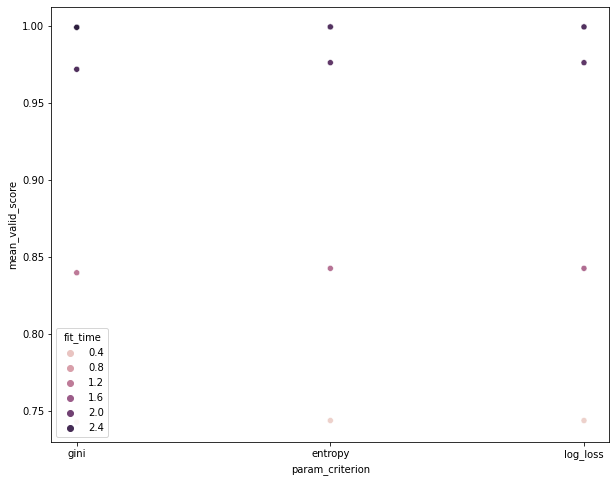

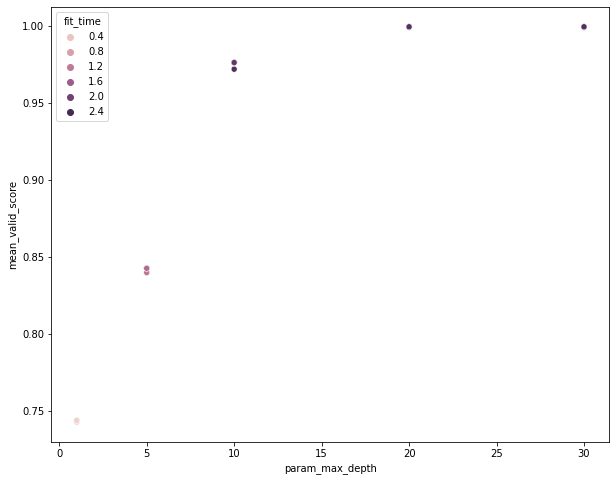

In [9]:
func_plot_gridsearch(clf.cv_results_)

# zad 3
## przetrenowanie i niedotrenowanie

- na podstawie poniżej generowanych danych proszę o przygotowanie obliczeń i wizualizacji pokazującej jak zwiększanie złożoności modelu wpływa na jakość treningu i ocenę modelu (dowolny 1 model)

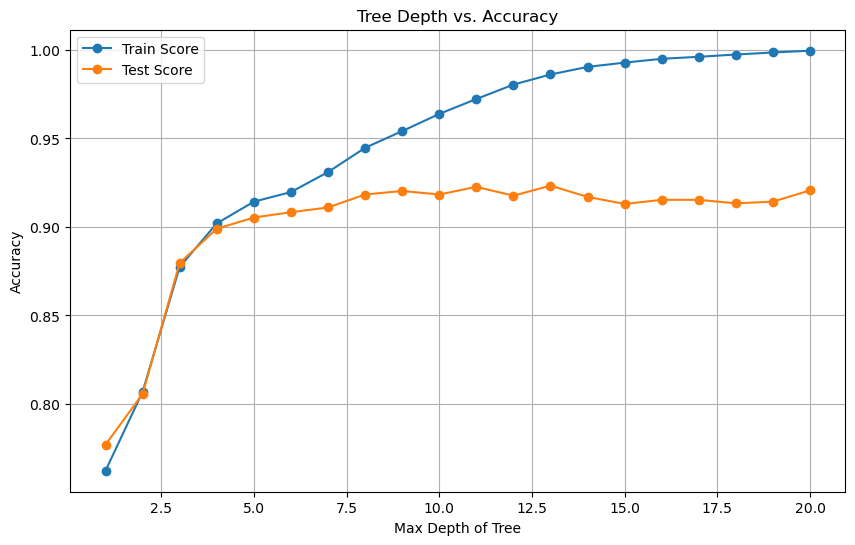

In [47]:

from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score  # Dodajemy import

x, y = make_classification(n_samples=10000, n_features=20, n_informative=5, n_redundant=15, random_state=1)

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3)
                                                    
max_depths = range(1, 21) 
train_scores = []
test_scores = []

for depth in max_depths:
    model = DecisionTreeClassifier(max_depth=depth, random_state=42)
    model.fit(x_train, y_train)
    
    train_score = accuracy_score(y_train, model.predict(x_train))
    test_score = accuracy_score(y_test, model.predict(x_test))
    
    train_scores.append(train_score)
    test_scores.append(test_score)

plt.figure(figsize=(10, 6))
plt.plot(max_depths, train_scores, label='Train Score', marker='o')
plt.plot(max_depths, test_scores, label='Test Score', marker='o')
plt.xlabel('Max Depth of Tree')
plt.ylabel('Accuracy')
plt.title('Tree Depth vs. Accuracy')
plt.legend()
plt.grid(True)
plt.show()